In [1]:
from functools import partial
from fvhoe.boundary_conditions import BoundaryCondition
from fvhoe.initial_conditions import double_shock_1d
from fvhoe.named_array import NamedNumpyArray
from fvhoe.solver import EulerSolver
from fvhoe.visualization import plot_1d_slice
import matplotlib.pyplot as plt
import numpy as np
import os
from pickle import dump, load
import sys
import warnings

warnings.filterwarnings("ignore")

sd_path = "../../../sd/"

sys.path.append(sd_path + "src")
sys.path.append(sd_path + "utils")
sys.path.append(sd_path + "ODE")

from initial_conditions_2d import blast_wave_test
from sd_simulator import SD_Simulator
import sd_visualize as sdv

CuPy not available, falling back to NumPy


In [2]:
N = 60
p = 3
T = 0.038
gamma = 1.4

n_dofs = N * (p + 1)

In [3]:
# solve with finite volumes

overwrite = False

try:
    with open("../../snapshots/interacting_blast_waves/arrs.pkl", "rb") as f:
        if overwrite:
            raise FileNotFoundError
        fv = load(f)
        print("Snapshot found!")
except FileNotFoundError:
    fv = EulerSolver(
        w0=partial(double_shock_1d),
        nx=n_dofs,
        px=p,
        riemann_solver="hllc3",
        bc=BoundaryCondition(
            x={
                "rho": "reflective",
                "E": "reflective",
                "mx": "negative-reflective",
                "my": "periodic",
                "mz": "periodic",
            }
        ),
        gamma=gamma,
        a_posteriori_slope_limiting=True,
        density_floor=True,
        pressure_floor=True,
        slope_limiter="minmod",
        snapshot_dir="../../snapshots",
    )

    fv.rkorder(T, filename="interacting_blast_waves", overwrite=overwrite)

100%|██████████| 0.038/0.038 [00:50]                 

Snapshots saved to ../../snapshots/interacting_blast_waves


In [5]:
# solve with spectral differences

try:
    with open("../../snapshots/interacting_blast_waves_sd/arrs.pkl", "rb") as f:
        sd = load(f)
    print("Snapshot found!")
except FileNotFoundError:
    sd = SD_Simulator(
        n=p,
        Nx=N,
        Ny=1,
        init_fct=blast_wave_test,
        BC=["reflex", "periodic"],
        gamma=gamma,
        detect_troubles=True,
        PAD=True,
        convex_combo=True,
        use_cupy=False,
    )
    sd.perform_time_evolution(T)

    # create fake snapshot
    W = sd.transpose_to_fv(sd.dm.W_cv)
    x = sd.dm.x_cv[2:-2]

    log = dict(
        x=x,
        y=np.array([0.5]),
        z=np.array([0.5]),
        t=sd.time,
        w=NamedNumpyArray(
            W[:, 0, ...].reshape(5, n_dofs, 1, 1), ["rho", "vx", "vy", "P", "h"]
        ),
    )
    sd = [log]

    # save
    if not os.path.exists("../../snapshots/interacting_blast_waves_sd"):
        os.makedirs("../../snapshots/interacting_blast_waves_sd")
    with open("../../snapshots/interacting_blast_waves_sd/arrs.pkl", "wb") as f:
        dump(sd, f)

1580 time steps (t = 0.038, Execution time: 31.918038 s)19761135707924, min p = 18.169137681730316))5)7)


t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50
t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50
t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50
t=0.04, x=[0.00, 1.00], y=0.50, z=0.50


Text(0.5, 0, '$x$')

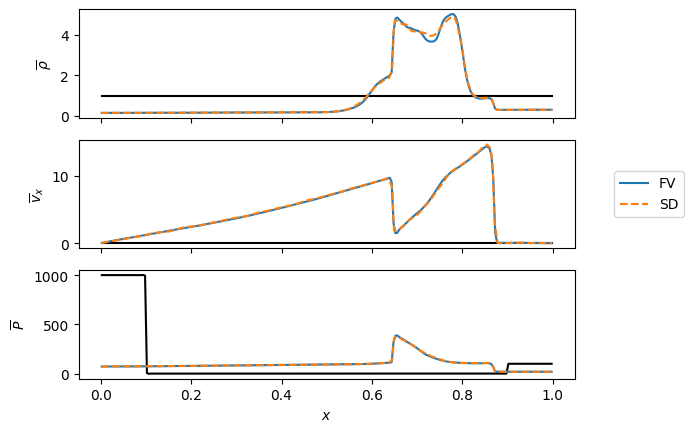

In [6]:
fig, ax = plt.subplots(3, sharex=True)

for i, (var, label) in enumerate(
    zip(
        ["rho", "vx", "P"],
        [r"$\overline{\rho}$", r"$\overline{v}_x$", r"$\overline{P}$"],
    )
):
    plot_1d_slice(fv, ax[i], y=0.5, z=0.5, t=0, color="k", param=var)
    plot_1d_slice(fv, ax[i], y=0.5, z=0.5, param=var, label="FV")
    plot_1d_slice(sd, ax[i], y=0.5, z=0.5, param=var, linestyle="--", label="SD")
    ax[i].set_ylabel(label)

ax[1].legend(loc="center", bbox_to_anchor=(1.15, 0.5))
ax[2].set_xlabel("$x$")